In [3]:
from tensorflow.keras import models, layers, optimizers, callbacks, backend
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=150
import time
import pickle
import sys

/Users/nicolas/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/nicolas/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file 

In [4]:
data1 = np.load("training/data/1OverF_1.npz")
c_data = data1['arr_0']       # C data
T_in = data1['arr_1']         # Time vector for data generation 
s_data = data1['arr_2']       # S data
w0 = data1['arr_3']           # Omega vector for data generation
T_train = data1['arr_4']      # Time vector for training data (based on the experimental data)
w_train = data1['arr_5']      # Omega vector for training data
T2_span = data1['arr_6']      # T2 distribution

In [5]:
# For data interpolation
def interpData(x,y,xNew):
    f_interp = interp1d(x,y)
    yNew = f_interp(xNew)
    return yNew

# For preparing training data: Add random noise, then replace low values with zeros
# Run this cell multiple times to generate sets with different random noise but same underlying curves
def prepare_trainData(c_in,T_in,T_train,noiseMax=0.03,cutOff=0.03):
    c_train = interpData(T_in,c_in,T_train)
    for i in range(c_in.shape[0]):
        c_train[i,:] = c_train[i,:] + np.random.normal(0,noiseMax*2/3,size=c_train.shape[1])
        cut = np.squeeze(np.argwhere(c_train[i,:]<=cutOff+np.random.normal(0,noiseMax*2/3,1)))
    if cut.size > 1:
        c_train[i,cut[0]-1:] = 0
    elif cut.size == 1:
        c_train[i,cut-1:] = 0
    return c_train

In [6]:
nnps = 6 #-- noise number per sample
# Interpolate, add random noise to experimental conditions, cut the tail of the data
c_train_1set = prepare_trainData( c_data, T_in, T_train )
s_train_1set = interpData( w0, s_data, w_train )
d1 = np.shape( c_train_1set )[0]
d2 = np.shape( c_train_1set )[1]
d3 = np.shape( s_train_1set )[1]
c_train = np.zeros( ( d1*nnps, d2 ) )
s_train = np.zeros( ( d1*nnps, d3 ) )
for i in range(nnps):
    c_train_1set = prepare_trainData( c_data, T_in, T_train, noiseMax=0.015,cutOff=0.03 )
    c_train[i*d1:(i+1)*d1,:] = c_train_1set
    s_train[i*d1:(i+1)*d1,:] = s_train_1set

X = c_train
y = s_train
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)    

print("x_train = ",np.shape(x_train))
print("y_train = ",np.shape(y_train))
print("x_test = ",np.shape(x_test))
print("y_test = ",np.shape(y_test))
print("w0 = ",np.shape(w0))
print("w_train = ",np.shape(w_train))

x_train =  (30064, 147)
y_train =  (30064, 501)
x_test =  (5306, 147)
y_test =  (5306, 501)
w0 =  (4001,)
w_train =  (501,)


In [7]:
def get_model( filter_nb, kernel_size, pool_size, dropout_rate ):
    model = models.Sequential()
    model.add( layers.Input( shape=(x_train.shape[-1], 1) ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D(pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//2, kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//8,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )

    model.add( layers.Conv1D( filter_nb//8,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )    
    model.add( layers.Conv1D( filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) ) 
    model.add( layers.Conv1D( 1, kernel_size, activation="relu", padding='same' ) )
    model.add( layers.Flatten() )
    model.add( layers.Dropout( dropout_rate ) )
    model.add( layers.Dense(501, activation='linear') )  
    
    return model 

In [8]:
BATCH_SIZE = 64
EPOCHS = 20
INIT_LR = 1e-5
MAX_LR = 1e-3

model = get_model( filter_nb=80, kernel_size=48, pool_size=2, dropout_rate=0.05 )
model.summary()

Metal device set to: Apple M1


2023-07-04 17:27:52.965996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-04 17:27:52.966396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 147, 80)           3920      
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 80)           307280    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 80)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 74, 40)            153640    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 40)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 37, 20)            3

## SINGLE MODEL TRAINING

In [9]:
LR=0.001
BATCH_SIZE = 64
EPOCHS1 = 4*30

model = get_model( filter_nb=40, kernel_size=42, pool_size=2, dropout_rate=0.05 )

opt = optimizers.Adam(learning_rate=LR)
model.compile(loss='MAPE', optimizer=opt)
history1_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS1,\
                         validation_data=(x_test, y_test), verbose=True )

EPOCHS2 = 4*30
INIT_LR = 3e-4
MAX_LR = 1e-3
steps_per_epoch = len(x_train) // BATCH_SIZE

clr2 = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        maximal_learning_rate=MAX_LR,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * steps_per_epoch)
opt = optimizers.Adam(clr2)
model.compile(loss='MAPE', optimizer=opt)
history2_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS2,\
                         validation_data=(x_test, y_test), verbose=True )

EPOCHS3 = 4*30
INIT_LR = 1e-4
MAX_LR = 3e-4
steps_per_epoch = len(x_train) // BATCH_SIZE

clr3 = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        maximal_learning_rate=MAX_LR,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * steps_per_epoch)
opt = optimizers.Adam(clr3)
model.compile(loss='MAPE', optimizer=opt)
history3_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS3,\
                         validation_data=(x_test, y_test), verbose=True )

EPOCHS4 = 4*30
INIT_LR = 3e-5
MAX_LR = 1e-4
steps_per_epoch = len(x_train) // BATCH_SIZE

clr4 = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        maximal_learning_rate=MAX_LR,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * steps_per_epoch)
opt = optimizers.Adam(clr4)
model.compile(loss='MAPE', optimizer=opt)
history4_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS4,\
                         validation_data=(x_test, y_test), verbose=True )

EPOCHS5 = 4*200
INIT_LR = 2e-6
MAX_LR = 3e-5
steps_per_epoch = len(x_train) // BATCH_SIZE

clr5 = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        maximal_learning_rate=MAX_LR,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * steps_per_epoch)
opt = optimizers.Adam(clr5)
model.compile(loss='MAPE', optimizer=opt)
history5_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS5,\
                         validation_data=(x_test, y_test), verbose=True )

model.save('training/CNN_1_FULL_LAYERS_LASTEST_fil=40_4_CLRs_extra_layer', overwrite=True)

Epoch 1/120


2023-07-04 17:27:57.147495: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-04 17:27:57.711356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 65.4802

2023-07-04 17:28:16.808858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 21s 41ms/step - loss: 65.4802 - val_loss: 24.9730
Epoch 2/120
470/470 [==============================] - 18s 39ms/step - loss: 21.3512 - val_loss: 28.8630
Epoch 3/120
470/470 [==============================] - 18s 39ms/step - loss: 14.7783 - val_loss: 11.3897
Epoch 4/120
470/470 [==============================] - 18s 39ms/step - loss: 12.0835 - val_loss: 12.5799
Epoch 5/120
470/470 [==============================] - 18s 39ms/step - loss: 11.6686 - val_loss: 9.9726
Epoch 6/120
470/470 [==============================] - 18s 39ms/step - loss: 10.1531 - val_loss: 8.1953
Epoch 7/120
470/470 [==============================] - 19s 41ms/step - loss: 9.4232 - val_loss: 8.1387
Epoch 8/120
470/470 [==============================] - 19s 40ms/step - loss: 8.8206 - val_loss: 8.1234
Epoch 9/120
470/470 [==============================] - 19s 40ms/step - loss: 8.9517 - val_loss: 8.3800
Epoch 10/120
470/470 [==============================] - 19s 41ms/step - los

Epoch 80/120
470/470 [==============================] - 19s 39ms/step - loss: 5.4036 - val_loss: 5.6447
Epoch 81/120
470/470 [==============================] - 19s 39ms/step - loss: 5.5143 - val_loss: 5.2392
Epoch 82/120
470/470 [==============================] - 18s 39ms/step - loss: 5.6172 - val_loss: 4.8364
Epoch 83/120
470/470 [==============================] - 18s 39ms/step - loss: 5.5796 - val_loss: 4.8732
Epoch 84/120
470/470 [==============================] - 18s 39ms/step - loss: 5.3735 - val_loss: 4.8324
Epoch 85/120
470/470 [==============================] - 19s 40ms/step - loss: 5.5072 - val_loss: 7.2576
Epoch 86/120
470/470 [==============================] - 18s 39ms/step - loss: 5.3225 - val_loss: 5.0249
Epoch 87/120
470/470 [==============================] - 19s 40ms/step - loss: 5.3454 - val_loss: 7.4556
Epoch 88/120
470/470 [==============================] - 19s 39ms/step - loss: 5.2818 - val_loss: 5.1420
Epoch 89/120
470/470 [==============================] - 18s 39ms

2023-07-04 18:05:16.436255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 4.6265

2023-07-04 18:05:36.066368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 22s 43ms/step - loss: 4.6265 - val_loss: 5.4268
Epoch 2/120
470/470 [==============================] - 19s 40ms/step - loss: 4.9218 - val_loss: 5.6393
Epoch 3/120
470/470 [==============================] - 19s 40ms/step - loss: 5.1741 - val_loss: 4.8569
Epoch 4/120
470/470 [==============================] - 19s 40ms/step - loss: 4.5913 - val_loss: 4.3836
Epoch 5/120
470/470 [==============================] - 19s 40ms/step - loss: 4.3715 - val_loss: 4.2713
Epoch 6/120
470/470 [==============================] - 19s 40ms/step - loss: 4.6299 - val_loss: 5.1170
Epoch 7/120
470/470 [==============================] - 19s 40ms/step - loss: 4.6236 - val_loss: 4.2481
Epoch 8/120
470/470 [==============================] - 19s 40ms/step - loss: 4.2920 - val_loss: 4.5217
Epoch 9/120
470/470 [==============================] - 19s 40ms/step - loss: 4.3010 - val_loss: 4.2108
Epoch 10/120
470/470 [==============================] - 19s 40ms/step - loss: 4.4422 

Epoch 80/120
470/470 [==============================] - 19s 40ms/step - loss: 4.0131 - val_loss: 4.2865
Epoch 81/120
470/470 [==============================] - 19s 40ms/step - loss: 4.0488 - val_loss: 4.3543
Epoch 82/120
470/470 [==============================] - 19s 40ms/step - loss: 4.0198 - val_loss: 4.1318
Epoch 83/120
470/470 [==============================] - 19s 40ms/step - loss: 4.1328 - val_loss: 4.9615
Epoch 84/120
470/470 [==============================] - 19s 40ms/step - loss: 4.0219 - val_loss: 4.1884
Epoch 85/120
470/470 [==============================] - 19s 40ms/step - loss: 3.9959 - val_loss: 4.2119
Epoch 86/120
470/470 [==============================] - 19s 40ms/step - loss: 4.0565 - val_loss: 5.2811
Epoch 87/120
470/470 [==============================] - 19s 40ms/step - loss: 3.9740 - val_loss: 5.0455
Epoch 88/120
470/470 [==============================] - 19s 40ms/step - loss: 4.0308 - val_loss: 4.2144
Epoch 89/120
470/470 [==============================] - 19s 40ms

2023-07-04 18:42:34.081905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 3.7801

2023-07-04 18:42:54.444965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 22s 44ms/step - loss: 3.7801 - val_loss: 4.1855
Epoch 2/120
470/470 [==============================] - 19s 40ms/step - loss: 3.9517 - val_loss: 5.0891
Epoch 3/120
470/470 [==============================] - 19s 40ms/step - loss: 3.8431 - val_loss: 4.0889
Epoch 4/120
470/470 [==============================] - 19s 40ms/step - loss: 3.7320 - val_loss: 4.2387
Epoch 5/120
470/470 [==============================] - 19s 40ms/step - loss: 3.6738 - val_loss: 4.5811
Epoch 6/120
470/470 [==============================] - 19s 40ms/step - loss: 3.7709 - val_loss: 4.1494
Epoch 7/120
470/470 [==============================] - 19s 40ms/step - loss: 3.7690 - val_loss: 4.2479
Epoch 8/120
470/470 [==============================] - 19s 40ms/step - loss: 3.7040 - val_loss: 4.1812
Epoch 9/120
470/470 [==============================] - 19s 40ms/step - loss: 3.6314 - val_loss: 4.3105
Epoch 10/120
470/470 [==============================] - 19s 40ms/step - loss: 3.6850 

Epoch 80/120
470/470 [==============================] - 19s 40ms/step - loss: 3.4700 - val_loss: 5.2383
Epoch 81/120
470/470 [==============================] - 19s 40ms/step - loss: 3.5316 - val_loss: 4.5545
Epoch 82/120
470/470 [==============================] - 19s 40ms/step - loss: 3.5027 - val_loss: 4.3619
Epoch 83/120
470/470 [==============================] - 19s 40ms/step - loss: 3.4852 - val_loss: 4.4144
Epoch 84/120
470/470 [==============================] - 19s 40ms/step - loss: 3.4773 - val_loss: 4.2307
Epoch 85/120
470/470 [==============================] - 19s 40ms/step - loss: 3.4860 - val_loss: 4.3628
Epoch 86/120
470/470 [==============================] - 19s 40ms/step - loss: 3.5478 - val_loss: 4.2072
Epoch 87/120
470/470 [==============================] - 19s 40ms/step - loss: 3.4635 - val_loss: 4.1564
Epoch 88/120
470/470 [==============================] - 19s 41ms/step - loss: 3.4917 - val_loss: 4.0526
Epoch 89/120
470/470 [==============================] - 19s 40ms

2023-07-04 19:19:59.846526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 3.3754

2023-07-04 19:20:21.087070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 24s 45ms/step - loss: 3.3754 - val_loss: 4.4004
Epoch 2/120
470/470 [==============================] - 19s 40ms/step - loss: 3.4002 - val_loss: 5.1247
Epoch 3/120
470/470 [==============================] - 19s 40ms/step - loss: 3.4378 - val_loss: 4.4146
Epoch 4/120
470/470 [==============================] - 19s 40ms/step - loss: 3.3422 - val_loss: 4.4421
Epoch 5/120
470/470 [==============================] - 19s 40ms/step - loss: 3.3217 - val_loss: 4.4866
Epoch 6/120
470/470 [==============================] - 19s 40ms/step - loss: 3.3609 - val_loss: 4.2869
Epoch 7/120
470/470 [==============================] - 19s 41ms/step - loss: 3.3584 - val_loss: 4.3897
Epoch 8/120
470/470 [==============================] - 19s 40ms/step - loss: 3.3210 - val_loss: 4.1451
Epoch 9/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2961 - val_loss: 4.3663
Epoch 10/120
470/470 [==============================] - 19s 40ms/step - loss: 3.3187 

Epoch 80/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2543 - val_loss: 4.5102
Epoch 81/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2497 - val_loss: 4.6242
Epoch 82/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2503 - val_loss: 5.0247
Epoch 83/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2449 - val_loss: 4.4465
Epoch 84/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2367 - val_loss: 4.0175
Epoch 85/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2434 - val_loss: 4.2881
Epoch 86/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2413 - val_loss: 4.2461
Epoch 87/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2348 - val_loss: 4.0390
Epoch 88/120
470/470 [==============================] - 19s 40ms/step - loss: 3.2347 - val_loss: 4.4038
Epoch 89/120
470/470 [==============================] - 19s 40ms

2023-07-04 19:57:27.279889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 3.1850

2023-07-04 19:57:48.435298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 24s 46ms/step - loss: 3.1850 - val_loss: 4.0805
Epoch 2/800
470/470 [==============================] - 19s 40ms/step - loss: 3.2027 - val_loss: 5.2993
Epoch 3/800
470/470 [==============================] - 19s 40ms/step - loss: 3.2165 - val_loss: 4.3164
Epoch 4/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1580 - val_loss: 4.1801
Epoch 5/800
470/470 [==============================] - 19s 41ms/step - loss: 3.1482 - val_loss: 4.2248
Epoch 6/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1739 - val_loss: 4.2319
Epoch 7/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1711 - val_loss: 4.3809
Epoch 8/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1525 - val_loss: 4.2620
Epoch 9/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1491 - val_loss: 4.3175
Epoch 10/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1584 

Epoch 80/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1313 - val_loss: 4.3884
Epoch 81/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1360 - val_loss: 4.2166
Epoch 82/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1405 - val_loss: 4.2255
Epoch 83/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1364 - val_loss: 4.1875
Epoch 84/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1376 - val_loss: 4.2623
Epoch 85/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1326 - val_loss: 4.1801
Epoch 86/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1352 - val_loss: 4.3399
Epoch 87/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1403 - val_loss: 4.3753
Epoch 88/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1379 - val_loss: 4.1900
Epoch 89/800
470/470 [==============================] - 19s 40ms

470/470 [==============================] - 19s 40ms/step - loss: 3.1318 - val_loss: 4.2316
Epoch 159/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1305 - val_loss: 4.2541
Epoch 160/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1361 - val_loss: 4.3095
Epoch 161/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1278 - val_loss: 4.2118
Epoch 162/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1280 - val_loss: 4.2430
Epoch 163/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1313 - val_loss: 4.3977
Epoch 164/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1355 - val_loss: 4.2827
Epoch 165/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1357 - val_loss: 4.2113
Epoch 166/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1308 - val_loss: 4.2839
Epoch 167/800
470/470 [==============================] - 19s 40ms/ste

470/470 [==============================] - 19s 40ms/step - loss: 3.1271 - val_loss: 4.2146
Epoch 237/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1275 - val_loss: 4.2668
Epoch 238/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1313 - val_loss: 4.3447
Epoch 239/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1230 - val_loss: 4.2794
Epoch 240/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1279 - val_loss: 4.3200
Epoch 241/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1253 - val_loss: 4.3130
Epoch 242/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1289 - val_loss: 4.2585
Epoch 243/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1259 - val_loss: 4.3634
Epoch 244/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1290 - val_loss: 4.2134
Epoch 245/800
470/470 [==============================] - 19s 40ms/ste

470/470 [==============================] - 19s 40ms/step - loss: 3.1254 - val_loss: 4.2394
Epoch 315/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1242 - val_loss: 4.3344
Epoch 316/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1226 - val_loss: 4.2688
Epoch 317/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1280 - val_loss: 4.1887
Epoch 318/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1229 - val_loss: 4.2709
Epoch 319/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1238 - val_loss: 4.2671
Epoch 320/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1233 - val_loss: 4.2796
Epoch 321/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1232 - val_loss: 4.2358
Epoch 322/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1249 - val_loss: 4.3974
Epoch 323/800
470/470 [==============================] - 19s 40ms/ste

470/470 [==============================] - 19s 40ms/step - loss: 3.1178 - val_loss: 4.3094
Epoch 393/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1195 - val_loss: 4.2715
Epoch 394/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1162 - val_loss: 4.3219
Epoch 395/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1180 - val_loss: 4.2129
Epoch 396/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1192 - val_loss: 4.2929
Epoch 397/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1171 - val_loss: 4.3453
Epoch 398/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1141 - val_loss: 4.2605
Epoch 399/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1184 - val_loss: 4.3916
Epoch 400/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1194 - val_loss: 4.2114
Epoch 401/800
470/470 [==============================] - 19s 40ms/ste

470/470 [==============================] - 19s 40ms/step - loss: 3.1200 - val_loss: 4.3277
Epoch 471/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1202 - val_loss: 4.1870
Epoch 472/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1131 - val_loss: 4.1746
Epoch 473/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1121 - val_loss: 4.2639
Epoch 474/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1059 - val_loss: 4.1786
Epoch 475/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1156 - val_loss: 4.2282
Epoch 476/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1120 - val_loss: 4.2925
Epoch 477/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1120 - val_loss: 4.3938
Epoch 478/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1134 - val_loss: 4.2040
Epoch 479/800
470/470 [==============================] - 19s 40ms/ste

470/470 [==============================] - 19s 40ms/step - loss: 3.1109 - val_loss: 4.2993
Epoch 549/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1131 - val_loss: 4.1791
Epoch 550/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1115 - val_loss: 4.2746
Epoch 551/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1047 - val_loss: 4.2555
Epoch 552/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1071 - val_loss: 4.3366
Epoch 553/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1096 - val_loss: 4.2730
Epoch 554/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1020 - val_loss: 4.3592
Epoch 555/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1067 - val_loss: 4.3477
Epoch 556/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1087 - val_loss: 4.2774
Epoch 557/800
470/470 [==============================] - 19s 40ms/ste

470/470 [==============================] - 19s 40ms/step - loss: 3.1099 - val_loss: 4.2701
Epoch 627/800
470/470 [==============================] - 19s 39ms/step - loss: 3.1081 - val_loss: 4.2459
Epoch 628/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1054 - val_loss: 4.2990
Epoch 629/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1075 - val_loss: 4.3295
Epoch 630/800
470/470 [==============================] - 19s 41ms/step - loss: 3.1132 - val_loss: 4.2117
Epoch 631/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1031 - val_loss: 4.1858
Epoch 632/800
470/470 [==============================] - 19s 39ms/step - loss: 3.1095 - val_loss: 4.3253
Epoch 633/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1074 - val_loss: 4.2668
Epoch 634/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1065 - val_loss: 4.2915
Epoch 635/800
470/470 [==============================] - 19s 40ms/ste

470/470 [==============================] - 19s 40ms/step - loss: 3.1038 - val_loss: 4.3387
Epoch 705/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1019 - val_loss: 4.2479
Epoch 706/800
470/470 [==============================] - 19s 41ms/step - loss: 3.1025 - val_loss: 4.3067
Epoch 707/800
470/470 [==============================] - 19s 40ms/step - loss: 3.0986 - val_loss: 4.2924
Epoch 708/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1001 - val_loss: 4.3016
Epoch 709/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1057 - val_loss: 4.2513
Epoch 710/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1049 - val_loss: 4.3914
Epoch 711/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1014 - val_loss: 4.3936
Epoch 712/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1046 - val_loss: 4.2032
Epoch 713/800
470/470 [==============================] - 19s 40ms/ste

470/470 [==============================] - 19s 40ms/step - loss: 3.1013 - val_loss: 4.2665
Epoch 783/800
470/470 [==============================] - 19s 40ms/step - loss: 3.1028 - val_loss: 4.2162
Epoch 784/800
470/470 [==============================] - 19s 40ms/step - loss: 3.0996 - val_loss: 4.3201
Epoch 785/800
470/470 [==============================] - 19s 40ms/step - loss: 3.0994 - val_loss: 4.2350
Epoch 786/800
470/470 [==============================] - 19s 40ms/step - loss: 3.0995 - val_loss: 4.3028
Epoch 787/800
470/470 [==============================] - 19s 40ms/step - loss: 3.0989 - val_loss: 4.2276
Epoch 788/800
470/470 [==============================] - 19s 40ms/step - loss: 3.0935 - val_loss: 4.4043
Epoch 789/800
470/470 [==============================] - 19s 40ms/step - loss: 3.0956 - val_loss: 4.2193
Epoch 790/800
470/470 [==============================] - 19s 40ms/step - loss: 3.0973 - val_loss: 4.2373
Epoch 791/800
470/470 [==============================] - 19s 40ms/ste

INFO:tensorflow:Assets written to: training/CNN_1_FULL_LAYERS_LASTEST_fil=40_4_CLRs/assets


INFO:tensorflow:Assets written to: training/CNN_1_FULL_LAYERS_LASTEST_fil=40_4_CLRs/assets


In [11]:
model.save('training/CNN_1_FULL_LAYERS_LASTEST_fil=40_4_CLRs_extra_layer', overwrite=True)

INFO:tensorflow:Assets written to: training/CNN_1_FULL_LAYERS_LASTEST_fil=40_4_CLRs_extra_layer/assets


INFO:tensorflow:Assets written to: training/CNN_1_FULL_LAYERS_LASTEST_fil=40_4_CLRs_extra_layer/assets


In [25]:
LR=0.001
BATCH_SIZE = 64
EPOCHS = 100

reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=8,verbose=True,\
    mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-5)
model = get_model( filter_nb=40, kernel_size=42, pool_size=2, dropout_rate=0.00 )
opt = optimizers.Adam(learning_rate=LR)
model.compile(loss='MAPE', optimizer=opt)
history_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS,\
                         validation_data=(x_test, y_test), verbose=True, callbacks=[reduce_lr])

Epoch 1/100


2023-07-03 14:46:52.023815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 60.8504

2023-07-03 14:47:10.858896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 21s 42ms/step - loss: 60.8504 - val_loss: 17.7559 - lr: 0.0010
Epoch 2/100
470/470 [==============================] - 18s 39ms/step - loss: 16.2726 - val_loss: 16.5582 - lr: 0.0010
Epoch 3/100
470/470 [==============================] - 18s 39ms/step - loss: 12.2798 - val_loss: 10.2124 - lr: 0.0010
Epoch 4/100
470/470 [==============================] - 19s 40ms/step - loss: 10.5823 - val_loss: 8.3483 - lr: 0.0010
Epoch 5/100
470/470 [==============================] - 18s 39ms/step - loss: 10.3188 - val_loss: 10.0389 - lr: 0.0010
Epoch 6/100
470/470 [==============================] - 18s 39ms/step - loss: 9.4746 - val_loss: 12.8719 - lr: 0.0010
Epoch 7/100
470/470 [==============================] - 18s 39ms/step - loss: 8.9361 - val_loss: 11.9728 - lr: 0.0010
Epoch 8/100
470/470 [==============================] - 18s 39ms/step - loss: 8.6484 - val_loss: 14.3465 - lr: 0.0010
Epoch 9/100
470/470 [==============================] - 18s 39ms/step - l

In [26]:
model.save('training/CNN_1_FULL_LAYERS_LASTEST_fil=40_add_4_filters_last_layer_dr=0', overwrite=True)

INFO:tensorflow:Assets written to: training/CNN_1_FULL_LAYERS_LASTEST_fil=40_add_4_filters_last_layer_dr=0/assets


INFO:tensorflow:Assets written to: training/CNN_1_FULL_LAYERS_LASTEST_fil=40_add_4_filters_last_layer_dr=0/assets


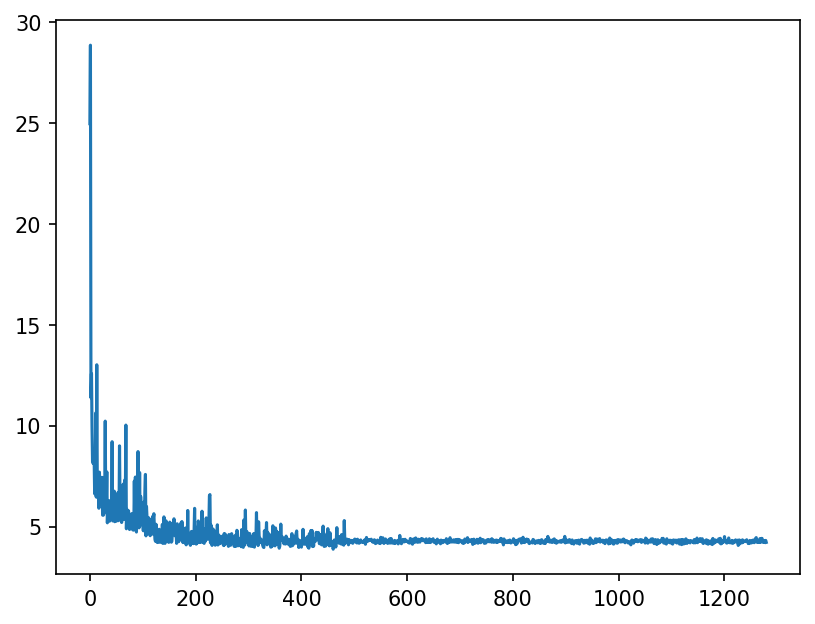

In [10]:
#tot_history = history_.history['val_loss'] 
tot_history = np.append( history1_.history['val_loss'],history2_.history['val_loss'] )
tot_history = np.append( tot_history,history3_.history['val_loss'] )
tot_history = np.append( tot_history,history4_.history['val_loss'] )
tot_history = np.append( tot_history,history5_.history['val_loss'] )

#epochs = np.arange( 0, EPOCHS )
epochs = np.arange( 0, EPOCHS1+EPOCHS2+EPOCHS3+EPOCHS4+EPOCHS5 )

plt.plot( epochs, tot_history )
plt.show()


## SWEEPING HYPER-PARAMETERS 

In [6]:
label1 = 'number_of_filters'
label2 = 'kernel_size'

parameters1_arr = np.arange( 20,60,1 )  #-- number of filters
parameters2_arr = np.arange( 20,60,1 )  #-- kernel size
batch_size_size_arr = [64]
pairs = []
for p1 in parameters1_arr:
    for p2 in parameters2_arr:
        pairs.append([p1,p2])
        
training_losses = {}
validation_losses = {}

nb_of_points = len(parameters1_arr)*len(parameters2_arr)
print(label1, parameters1_arr)
print(label2, parameters2_arr)
print(len(parameters1_arr),len(parameters2_arr),nb_of_points)

number_of_filters [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
kernel_size [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
40 40 1600


In [7]:
epochs0=15
epochs=30
best_loss = 1000
worst_loss = -1

t1=time.time()
print('-- nb of points =',nb_of_points )

from datetime import datetime
now = datetime.now()
t_string = now.strftime("%d_%m||%Hh%M")
print("-- t_string", t_string)

if (nb_of_points != len(pairs)):
    print("-- ABORT: parameter sweep already started.")
    sys.exit()


count=0
while pairs:
    
    count +=1
    rand_int = np.random.randint(0, len(pairs))
    pair = pairs[rand_int]
    p1 = int( pair[0] )
    p2 = int( pair[1] )
    pairs.remove(pair)

    print('.',end=' ' )
    
    for bs in batch_size_size_arr:
        
        steps_per_epoch = len(x_train) // bs
        model = get_model( filter_nb=p1, kernel_size=p2, pool_size=2, dropout_rate=0.05 )
        
        opt0 = optimizers.Adam(learning_rate=1e-3)
        model.compile(loss='MAPE', optimizer=opt0)
        history0_ = model.fit( x_train, y_train, bs, epochs=epochs0,\
                         validation_data=(x_test, y_test), verbose=True )
        
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-3,
            maximal_learning_rate=1e-5,
            scale_fn=lambda x: 1/(2.**(x-1)),
            step_size=2 * steps_per_epoch)
        opt = optimizers.Adam(clr)
        model.compile(loss='MAPE', optimizer=opt)
        history_ = model.fit( x_train, y_train, bs, epochs=epochs,\
                         validation_data=(x_test, y_test), verbose=True )

        training_losses[ p1 , p2, bs ] = history_.history['loss'][-1]
        validation_losses[ p1 ,p2, bs ] = history_.history['val_loss'][-1]
        if count > 1:
            with open('training/training_losses_'+t_string+'.pkl', 'wb') as f1:
                pickle.dump(training_losses, f1)
            with open('training/validation_losses_'+t_string+'.pkl', 'wb') as f2:
                pickle.dump(validation_losses, f2)

        if (validation_losses[ p1 , p2, bs ] < best_loss):
            model.save('training/best_model_'+t_string, overwrite=True)
            with open('training/best_history_'+t_string+'.pkl', 'wb') as f3:
                pickle.dump( history_.history , f3)
            best_loss = validation_losses[ p1 , p2, bs ]
            best_p1=p1
            best_p2=p2
        
        del model
        del history_
        

t2=time.time()
print(' ')
print('=== COMPLETE ===')
print("-- total time = ", t2-t1)
print("-- best {}, {} =".format(label1, label2), best_p1, best_p2)
print("-- t_string", t_string)


-- nb of points = 1600
-- t_string 02_07||19h57
. Metal device set to: Apple M1


2023-07-02 19:57:49.535741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-02 19:57:49.535954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2023-07-02 19:57:49.822730: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-02 19:57:50.256640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 63.9108

2023-07-02 19:58:11.640449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 23s 47ms/step - loss: 63.9108 - val_loss: 32.6534
Epoch 2/15
470/470 [==============================] - 21s 45ms/step - loss: 22.1640 - val_loss: 14.0177
Epoch 3/15
470/470 [==============================] - 21s 45ms/step - loss: 15.1503 - val_loss: 19.1488
Epoch 4/15
470/470 [==============================] - 21s 45ms/step - loss: 13.2534 - val_loss: 10.2155
Epoch 5/15
470/470 [==============================] - 21s 45ms/step - loss: 11.6085 - val_loss: 11.9352
Epoch 6/15
470/470 [==============================] - 21s 45ms/step - loss: 10.3233 - val_loss: 9.7022
Epoch 7/15
470/470 [==============================] - 21s 45ms/step - loss: 10.5816 - val_loss: 10.1785
Epoch 8/15
470/470 [==============================] - 21s 44ms/step - loss: 9.3932 - val_loss: 7.6645
Epoch 9/15
470/470 [==============================] - 21s 45ms/step - loss: 9.3921 - val_loss: 7.6289
Epoch 10/15
470/470 [==============================] - 21s 44ms/step - loss: 8.9

NameError: name 'steps_per_epoch' is not defined

Best parameters = number_of_filters kernel_size dr = 21 21 64 10.150657653808594


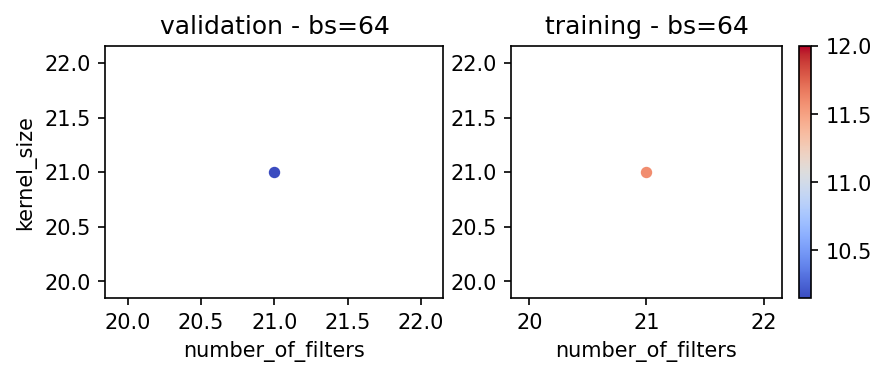

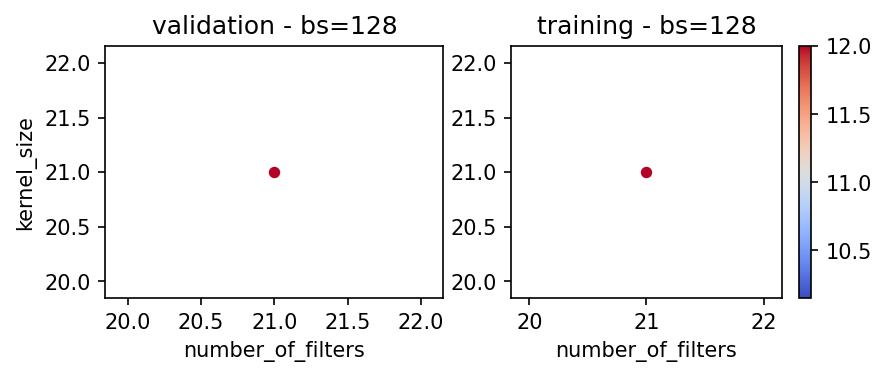

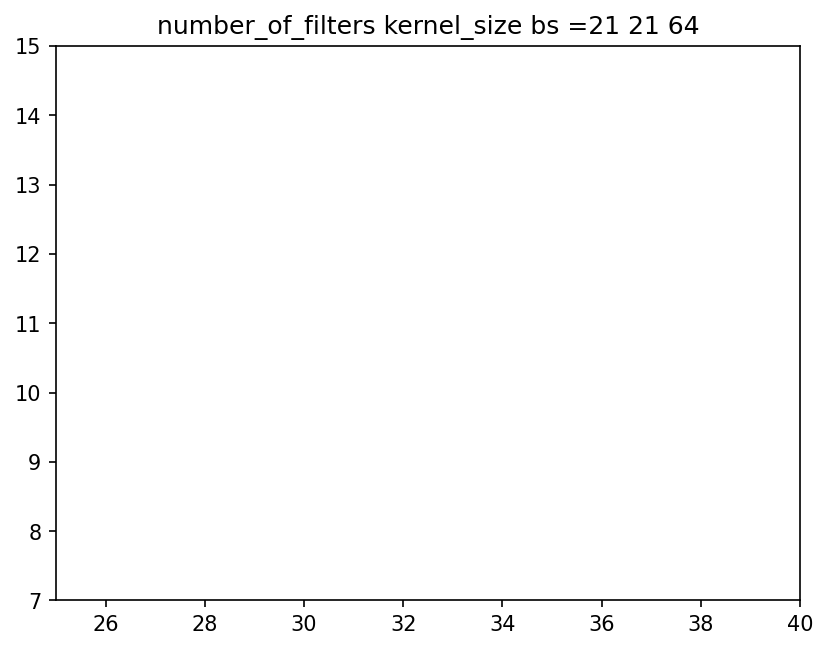

In [106]:
from collections import defaultdict

matplotlib.rcParams['figure.dpi']=150
t_string="02_07||19h42"
with open('training/training_losses_'+t_string+'.pkl', 'rb') as f1:
    training_losses = pickle.load(f1)
with open('training/validation_losses_'+t_string+'.pkl', 'rb') as f2:
    validation_losses = pickle.load(f2)
with open('training/best_history_'+t_string+'.pkl', 'rb') as f3:
    best_history = pickle.load(f3)


min_val = min(validation_losses, key=validation_losses.get)
print( "Best parameters = "+label1+" "+label2+' dr =', min_val[0], min_val[1],min_val[2],validation_losses[min_val] )

#x_scatter = [ x[0] for x in training_losses]
#y_scatter = [ x[1] for x in training_losses]

x_scatter = defaultdict(list)
y_scatter = defaultdict(list)
training_colors = defaultdict(list)
validation_colors = defaultdict(list)
for x in training_losses:
    x_scatter[x[2]].append(x[0])
    y_scatter[x[2]].append(x[1])
    training_colors[x[2]].append( training_losses[x]  )
    validation_colors[x[2]].append( validation_losses[x]  )


#training_colors = [training_losses[x] for x in training_losses]
#validation_colors = [validation_losses[x] for x in training_losses]


for key in x_scatter.keys():
    
    vals = list(validation_losses.values())
    
    plt.subplot(2,2,1)
    mycmap = plt.cm.coolwarm
    lognorm=matplotlib.colors.LogNorm()
    #plt.scatter( x_scatter, y_scatter, s=20, c=validation_colors, cmap=mycmap)#,norm=lognorm )
    plt.scatter( x_scatter[key], y_scatter[key], s=20, c=validation_colors[key], cmap=mycmap)#,norm=lognorm )
    plt.xlabel(label1)
    plt.ylabel(label2)
    #plt.clim( min(vals), max(vals) )
    plt.clim( min(vals), 12 )
    plt.title( 'validation - bs='+str(key) )

    plt.subplot(2,2,2)
    lognorm=matplotlib.colors.LogNorm()
    mycmap = plt.cm.coolwarm
    plt.scatter( x_scatter[key], y_scatter[key], s=20, c=training_colors[key], cmap=mycmap)#,norm=lognorm )
    plt.xlabel(label1)
    plt.title( 'training - bs='+str(key) )
    plt.clim( min(vals), 12 )
    #plt.clim( min(vals), max(vals) )
    plt.colorbar()
    
    plt.show()

plt.scatter( np.arange(len(best_history['val_loss'])), best_history['val_loss'], s=5 )
plt.plot( np.arange(len(best_history['loss'])), best_history['loss'], dashes=[2,2,2,2] )
plt.savefig('training/plots/'+t_string+'.pdf',format='pdf')
plt.title( label1+" "+label2+' bs ='+str(min_val[0])+" "+str(min_val[1])+" "+str(min_val[2]) )
plt.xlim(25,40)
plt.ylim(7,15)
plt.show()

##  MODEL TESTING

In [12]:
reconstructed_model = models.load_model("training/CNN_1_FULL_LAYERS_LASTEST_fil=40_4_CLRs_extra_layer", compile=False)

In [13]:
probability_model = tf.keras.Sequential([reconstructed_model])
#probability_model = tf.keras.Sequential([model])
predictions_best = probability_model.predict(x_test)

2023-07-05 15:10:24.430935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - 2s 11ms/step


(0.0, 500000.0)

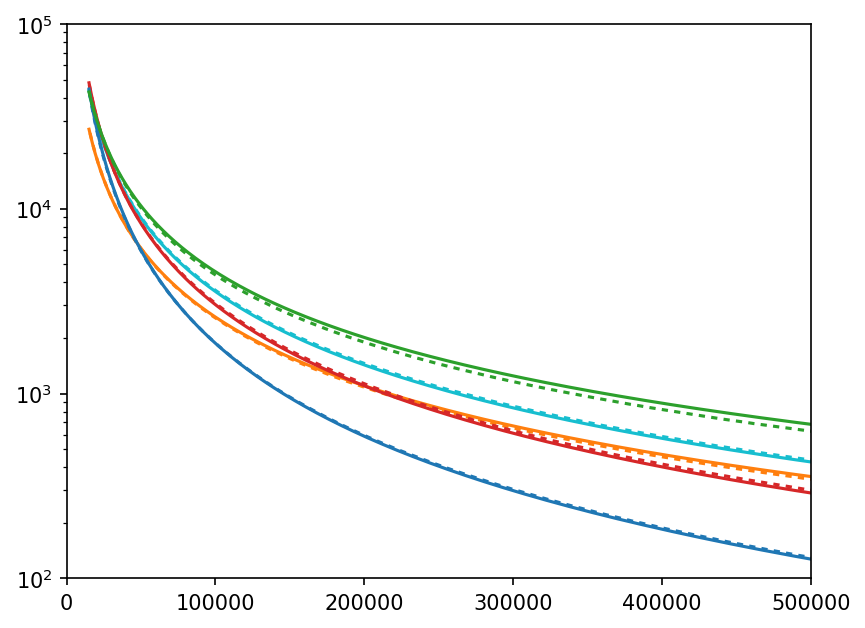

In [14]:
plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w_train, y_test[i,:],color='C'+str(i))
    plt.plot(w_train, predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e2,1e5)
plt.xlim(0, 0.5e6)

In [ ]:
matplotlib.rcParams['figure.dpi']=300
plt.subplot(1, 2, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(30,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')

plt.subplot(1, 2, 2)
for i in rand_set:
    plt.plot( x_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))